In [1]:
import pandas as pd
import seaborn as sns
import pylab as plt
df = pd.read_csv('https://raw.githubusercontent.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/master/Chapter1_Introduction/data/txtdata.csv', header = None)

# Estadística Bayesiana aplicada a los mensajes de texto.

**Problema**

Tenemos un set de datos que consiste en el conteo diario de mensajes de texto de una persona.

Cada día, nuestro individuo escribe n mensaje de texto.

In [6]:
print(df.head())
df.index

      0
0  13.0
1  24.0
2   8.0
3  24.0
4   7.0


RangeIndex(start=0, stop=74, step=1)

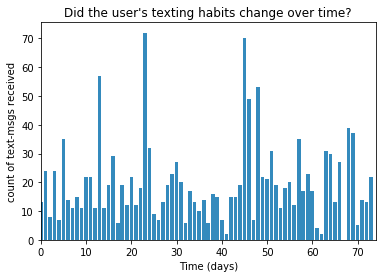

In [7]:
plt.bar(list(df.index), df[0].values, color="#348ABD")
plt.xlabel("Time (days)")
plt.ylabel("count of text-msgs received")
plt.title("Did the user's texting habits change over time?")
plt.xlim(0, len(df.index));

En algun momento, en los ~70 dias, la empresa cambio su tarifa de mensajes. Como descrubrimos en que dia fue, y como descubrimos si la persona en verdad cambio su comportamiento.

In [8]:
df[0].mean()

19.743243243243242

Al dia manda en promedio 20 mensajes, como calculariamos los promedios para diferentes periodos.

In [9]:
limit = 40
print(df[df.index<limit].mean().values)
print(df[df.index>limit].mean().values)

[18.525]
[21.60606061]


Le seguimos adivinando?

Hay 3 variables:


1.   Dia del cambio
2.   Promedio de mensajes antes del cambio
3.   Promedio de mensajes despues del cambio



## Num de Mensajes
Como se modela una variable de conteo?

Utilizamos la distribucion de [Poisson](https://en.wikipedia.org/wiki/Poisson_distribution).

[Siempre es conveniente saber que distribuciones modelan que tipos de eventos](https://web.cs.elte.hu/~mesti/valszam/kepletek)

In [10]:
from scipy.stats import poisson
import numpy as np
mu = 10 #Mu es un parametro que nos dice el numero promedio de mensajes (eventos)
poisson.stats(mu)

(array(10.), array(10.))

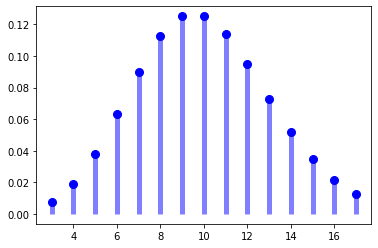

In [11]:
fig, ax = plt.subplots(1, 1)
x = np.arange(poisson.ppf(0.01, mu),
              poisson.ppf(0.99, mu))
ax.plot(x, poisson.pmf(x, mu), 'bo', ms=8, label='poisson pmf')
ax.vlines(x, 0, poisson.pmf(x, mu), colors='b', lw=5, alpha=0.5)

Cuantos parametros $\mu$ vamos a tener?

Recordemos que $\mu$ es el numero promedio en un periodo de tiempo.

2, uno para antes del cambio y otro despues del cambio.

$$
\mu = 
\begin{cases}
\mu_1 \text{if } t \lt \tau \cr
\mu_2 \text{if } t \ge \tau
\end{cases}
$$

Que pasaria en el caso de que no hubiera cambio en el comportamiento de nuestro cliente?

## Priors

Si queremos usar inferencia Bayesiana, tenemos que asignar priors a cada uno de los parametros $\mu$, una exponencial por lo general es una buena idea.


\begin{align}
&\lambda_1 \sim \text{Exp}( \alpha ) \\\
&\lambda_2 \sim \text{Exp}( \alpha )
\end{align}


# Dia del cambio de comportamiento

Es un dia entre los 70, que distribucion modela mejor elegir un valor de entre N enteros.

[Siempre es conveniente saber que distribuciones modelan que tipos de eventos](https://web.cs.elte.hu/~mesti/valszam/kepletek)

\begin{align}
\tau \sim \text{DiscreteUniform(1,70) }\\\\
\Rightarrow P( \tau = k ) = \frac{1}{70}
\end{align}

In [12]:
# conda install -c conda-forge pymc3
import pymc3 as pm
import theano.tensor as tt
count_data = df[0].values
n_count_data = len(count_data)
with pm.Model() as model:
    alpha = 1.0/count_data.mean()  # Recall count_data is the
                                   # variable that holds our txt counts
    lambda_1 = pm.Exponential("lambda_1", alpha)
    lambda_2 = pm.Exponential("lambda_2", alpha)
    
    tau = pm.DiscreteUniform("tau", lower=0, upper=n_count_data - 1)

In [13]:
with model:
    idx = np.arange(n_count_data) # Index
    lambda_ = pm.math.switch(tau > idx, lambda_1, lambda_2)

In [14]:
with model:
    observation = pm.Poisson("obs", lambda_, observed=count_data)

In [15]:
with model:
    step = pm.Metropolis()
    trace = pm.sample(10000, tune=5000,step=step)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [lambda_2]
>Metropolis: [lambda_1]
Sampling 4 chains, 0 divergences: 100%|█████████████████████████████████████| 60000/60000 [00:22<00:00, 2646.48draws/s]
The number of effective samples is smaller than 25% for some parameters.


In [16]:
lambda_1_samples = trace['lambda_1']
lambda_2_samples = trace['lambda_2']
tau_samples = trace['tau']

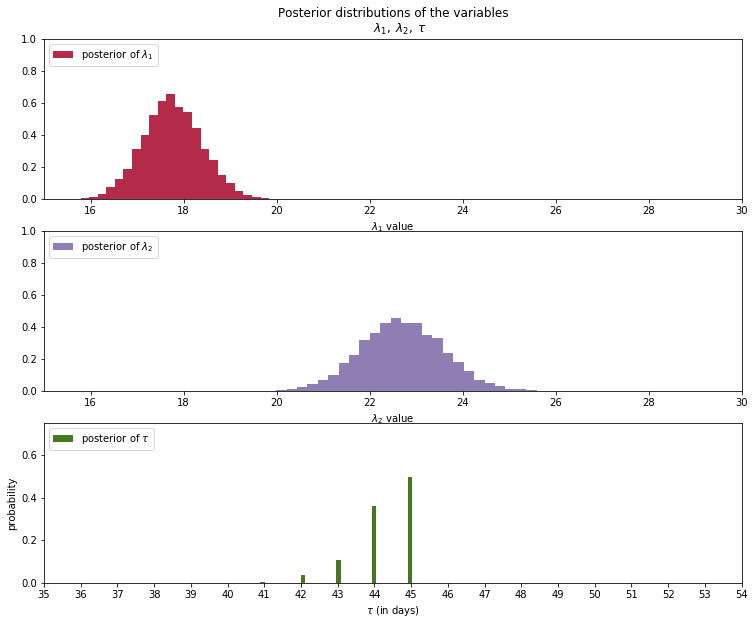

In [17]:
from IPython.core.pylabtools import figsize

figsize(12.5, 10)
#histogram of the samples:

ax = plt.subplot(311)
ax.set_autoscaley_on(False)

plt.hist(lambda_1_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_1$", color="#A60628", density=True)
plt.legend(loc="upper left")
plt.title(r"""Posterior distributions of the variables
    $\lambda_1,\;\lambda_2,\;\tau$""")
plt.xlim([15, 30])
plt.xlabel("$\lambda_1$ value")

ax = plt.subplot(312)
ax.set_autoscaley_on(False)
plt.hist(lambda_2_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_2$", color="#7A68A6", density=True)
plt.legend(loc="upper left")
plt.xlim([15, 30])
plt.xlabel("$\lambda_2$ value")

plt.subplot(313)
w = 1.0 / tau_samples.shape[0] * np.ones_like(tau_samples)
plt.hist(tau_samples, bins=n_count_data, alpha=1,
         label=r"posterior of $\tau$",
         color="#467821", weights=w, rwidth=2.)
plt.xticks(np.arange(n_count_data))

plt.legend(loc="upper left")
plt.ylim([0, .75])
plt.xlim([35, len(count_data)-20])
plt.xlabel(r"$\tau$ (in days)")
plt.ylabel("probability");